In [1]:
import pandas as pd

seed = pd.read_csv("data/2024_tourney_seeds.csv")

def compute_ncaa_bracket(seed):
    seed = seed[seed['Tournament'] == 'M']
    seed['Conference'] = seed['Seed'].str.slice(0,1)
    seed['Position'] = seed['Seed'].str.slice(-2).astype(int)

    df = pd.DataFrame(columns=['Conference', 'Game', 'TeamA', 'TeamB'])

    for conference in list(seed['Conference'].unique()):
        conf = seed[seed['Conference'] == conference]
        while not conf.empty:
            top_team = conf[conf['Position'] == conf['Position'].min()]
            low_team = conf[conf['Position'] == conf['Position'].max()]
            
            game = top_team['Seed'].values[0][1:] + low_team['Seed'].values[0][1:]
            
            df.loc[len(df)] = [conference, game, top_team['TeamID'].values[0], low_team['TeamID'].values[0]]
            
            conf = conf.drop(top_team.index, inplace=False, axis='index')
            conf = conf.drop(low_team.index, inplace=False, axis='index')

    next_df = df.copy()
    final_df = df.copy()

    while not next_df.empty and len(next_df) > 1:
        df = pd.DataFrame(columns=['Conference', 'Game', 'TeamA', 'TeamB'])
        for conference in list(next_df['Conference'].unique()):
            conf = next_df[next_df['Conference'] == conference]
            
            while not conf.empty and len(conf) > 1:
                top_team = conf[conf['Game'] == conf['Game'].min()]
                low_team = conf[conf['Game'] == conf['Game'].max()]
                game = top_team['Game'].values[0] +"_"+low_team['Game'].values[0]
                if top_team.index < low_team.index: 
                    final_df.loc[len(final_df)] = [conference, game, top_team['Game'].values[0], low_team['Game'].values[0]]
                else:
                    final_df.loc[len(final_df)] = [conference, game, low_team['Game'].values[0], top_team['Game'].values[0]]
                    
                
                df.loc[len(df)] = [conference, game, top_team['Game'].values[0], low_team['Game'].values[0]]
                conf = conf.drop(top_team.index, inplace=False, axis='index')
                conf = conf.drop(low_team.index, inplace=False, axis='index')
                
        next_df  = df.copy()


    return final_df

bracket = compute_ncaa_bracket(seed)

/tmp/ipykernel_2613/3022504918.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed['Conference'] = seed['Seed'].str.slice(0,1)
/tmp/ipykernel_2613/3022504918.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed['Position'] = seed['Seed'].str.slice(-2).astype(int)


In [2]:
def pregame_data(teamA, teamB, data, columns):

    home_columns = ['Home', 'HPF', 'HA2TR', 'HOffR', 'HAllR', 'HFGP', 'HPFR', 'HStreak']
    away_columns = ['Away', 'APF', 'AA2TR', 'AOffR', 'AAllR', 'AFGP', 'APFR', 'AStreak']
    # Cogemos el ultimmo partido de ambos equipos
    teamA_data = data[(data['Season'] == 2024) & ((data['Home'] == teamA) | (data['Away'] == teamA))].tail(1)
    teamB_data = data[(data['Season'] == 2024) & ((data['Home'] == teamB) | (data['Away'] == teamB))].tail(1)
    
    if teamA_data['Home'].values[0] == teamA:
        teamA_data = teamA_data[home_columns]
    else:
        teamA_data = teamA_data[away_columns]
        renamed_a2h_columns = {x:v for x,v in zip(away_columns, home_columns)}
        teamA_data = teamA_data.rename(columns=renamed_a2h_columns)

    if teamB_data['Home'].values[0] == teamB:
        teamB_data = teamB_data[home_columns]
        renamed_h2a_columns = {x:v for x,v in zip(home_columns, away_columns)}
        teamB_data = teamB_data.rename(columns=renamed_h2a_columns)
    else:
        teamB_data = teamB_data[away_columns]
    teamA_data.reset_index(inplace=True, drop=True)
    teamB_data.reset_index(inplace=True, drop=True)
    game = pd.concat([teamA_data, teamB_data], axis='columns')
    game['Season'] = 2024
    game['DayNum'] = 137
    game['Result'] = None
    
    return game[columns]
    
    
        

In [3]:
MedianSeasonAgg = pd.read_csv("data/MMedianSeasonAggStreak_2.csv")
MedianSeasonAgg.dropna(inplace=True)
MedianSeasonAgg

game = pregame_data(teamA=1345, teamB=1192, data=MedianSeasonAgg, columns=MedianSeasonAgg.columns)
game

,Season,DayNum,Home,Away,Result,HPF,HA2TR,HOffR,HAllR,HFGP,HPFR,APF,AA2TR,AOffR,AAllR,AFGP,APFR,HStreak,AStreak
0,2024,137,1345.0,1192.0,None,13.0,1.75,0.37037,0.584615,0.459459,0.405405,18.5,1.190909,0.256777,0.481517,0.394772,0.5,1.0,-1.0


In [4]:
game['DayNum'].values[0]

137

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

MedianSeasonAgg = pd.read_csv("data/MMedianSeasonAggStreak_2.csv")
MedianSeasonAgg.dropna(inplace=True)

# Separate X, Y for training
X = MedianSeasonAgg.drop(columns=['Result'])
Y = MedianSeasonAgg['Result']

# train test spllt
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# random forest

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(x_train, y_train)


def generate_prediction(game_data, model):
    game_data.drop(columns=['Result'], inplace=True)
    result = model.predict(game_data)
    if result == 1:
        return game_data['Home'].values[0]
    else:
        return game_data['Away'].values[0]
    

def predict_ncaa_bracket(bracket, season_data, model):
    for i in range(len(bracket)):
        game = bracket.loc[i, :]
        teamA, teamB, game_name, conference= game['TeamA'], game['TeamB'], game['Game'], game['Conference']
        print(f"Game: - {game_name}     Teams: {teamA} vs {teamB}")
        game_data = pregame_data(teamA=teamA, teamB=teamB, data=season_data, columns=season_data.columns)
        winner = generate_prediction(game_data=game_data, model=model)
        print(f"Game: - {game_name}     Teams: {teamA} vs {teamB}  --> Winner  {winner}")

        idx = bracket[(bracket['Conference'] == conference) & (bracket['TeamA'] == game_name)].index.values
        if len(idx)>0:
            idx = idx[0]
            bracket.at[idx, 'TeamA'] = winner
        
        idx = bracket[(bracket['Conference'] == conference) & (bracket['TeamB'] == game_name)].index.values
        if len(idx)>0:
            idx = idx[0]
            bracket.at[idx, 'TeamB'] = winner
        bracket.loc[(bracket['Conference'] == conference) & (bracket['Game'] == game_name), "Winner"] = winner
        

    return bracket
        
        


In [6]:
def add_teamsName_2_bracket_output(bracke_df, teams):
    merge = bracke_df.merge(teams, left_on='TeamA', right_on='TeamID')
    merge["TeamAName"] = merge["TeamName"]
    merge.drop(columns=["TeamID", "TeamName", "FirstD1Season", "LastD1Season"], inplace=True)
    merge = merge.merge(teams, left_on='TeamB', right_on='TeamID')
    merge["TeamBName"] = merge["TeamName"]
    merge.drop(columns=["TeamID", "TeamName", "FirstD1Season", "LastD1Season"], inplace=True)
    merge['level'] = merge['Game'].str.count('_')
    merge['level'] = merge['level'].apply(lambda x: list(merge['level'].unique()).index(x))

    
    return merge

In [7]:
def reorder_bracket_df(df):
    new_order = []
    level = list(df['level'].unique())
    for conf in list(df['Conference'].unique()):
        wconf = df[df['Conference'] == conf]
        for l in level:
            level_wconf = wconf[wconf['level'] == l]
            if l == 0:
                games = list(level_wconf.index)
                splits_top = [min(games[0: len(games) // 2]), max(games[0: len(games) // 2]), min(games[len(games) // 2 : ]), max(games[len(games) // 2: ])]
                for i in splits_top: games.remove(i)
                split_bottom = games.copy()
                # create order for split_top
                splits_top.reverse()
                splits_top.insert(0, splits_top[-1])
                splits_top.pop()
                # Create order for split_bottom
                split_bottom.reverse()
                split_bottom.insert(-1, split_bottom[0])
                del split_bottom[0]
                splits_top.extend(split_bottom)
                new_order.extend(splits_top)
                
            if l == 1:
                games = list(level_wconf.index)
                splits = [min(games), max(games), max(games[:-1]), min(games[1:])]
                new_order.extend(splits)
                print(splits)
            if l == 2:
                games = list(level_wconf.index)
                splits = [min(games), max(games)]
                new_order.extend(splits)
            if l == 3:
                games = list(level_wconf.index)
                new_order.extend(games)
    
    df_reordered = df.reindex(new_order)
    return df_reordered


        
    

In [8]:
def pipeline():
    seed = pd.read_csv("data/2024_tourney_seeds.csv")
    bracket = compute_ncaa_bracket(seed)
    MedianSeasonAgg = pd.read_csv("data/MMedianSeasonAggStreak_2.csv")
    MedianSeasonAgg.dropna(inplace=True)

    # Separate X, Y for training
    X = MedianSeasonAgg.drop(columns=['Result'])
    Y = MedianSeasonAgg['Result']

    # train test spllt
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # random forest

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x_train, y_train)
    
    solved_bracket = predict_ncaa_bracket(bracket=bracket, season_data=MedianSeasonAgg, model=model)
    
    final_four = solved_bracket.tail(4)
    teams = pd.read_csv('data/MTeams.csv')

    merge = add_teamsName_2_bracket_output(solved_bracket, teams)
    
    #merge = reorder_bracket_df(merge)
    
    return merge
    
    
    
    


In [11]:
test = pipeline()

/tmp/ipykernel_2613/3022504918.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed['Conference'] = seed['Seed'].str.slice(0,1)
/tmp/ipykernel_2613/3022504918.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed['Position'] = seed['Seed'].str.slice(-2).astype(int)


Game: - 0116     Teams: 1345 vs 1192
Game: - 0116     Teams: 1345 vs 1192  --> Winner  1192.0
Game: - 0215     Teams: 1266 vs 1436
Game: - 0215     Teams: 1266 vs 1436  --> Winner  1436.0
Game: - 0314     Teams: 1243 vs 1286
Game: - 0314     Teams: 1243 vs 1286  --> Winner  1286.0
Game: - 0413     Teams: 1397 vs 1418
Game: - 0413     Teams: 1397 vs 1418  --> Winner  1418.0
Game: - 0512     Teams: 1181 vs 1331
Game: - 0512     Teams: 1181 vs 1331  --> Winner  1331.0
Game: - 0611     Teams: 1246 vs 1344
Game: - 0611     Teams: 1246 vs 1344  --> Winner  1344.0
Game: - 0710     Teams: 1277 vs 1425
Game: - 0710     Teams: 1277 vs 1425  --> Winner  1425.0
Game: - 0809     Teams: 1272 vs 1194
Game: - 0809     Teams: 1272 vs 1194  --> Winner  1194.0
Game: - 0116     Teams: 1104 vs 1369
Game: - 0116     Teams: 1104 vs 1369  --> Winner  1369.0
Game: - 0215     Teams: 1112 vs 1343
Game: - 0215     Teams: 1112 vs 1343  --> Winner  1343.0
Game: - 0314     Teams: 1124 vs 1364
Game: - 0314     Teams:

In [12]:
test[test['Conference'] == 'W']

,Conference,Game,TeamA,TeamB,Winner,TeamAName,TeamBName,level
0,W,0116,1345,1192,1192.0,Purdue,F Dickinson,0
1,W,0215,1266,1436,1436.0,Marquette,Vermont,0
2,W,0314,1243,1286,1286.0,Kansas St,Montana St,0
3,W,0413,1397,1418,1418.0,Tennessee,Louisiana,0
4,W,0512,1181,1331,1331.0,Duke,Oral Roberts,0
5,W,0611,1246,1344,1344.0,Kentucky,Providence,0
6,W,0710,1277,1425,1425.0,Michigan St,USC,0
7,W,0809,1272,1194,1194.0,Memphis,FL Atlantic,0
32,W,0116_0809,1192.0,1194.0,1194.0,F Dickinson,FL Atlantic,1
33,W,0215_0710,1436.0,1425.0,1425.0,Vermont,USC,1


In [13]:

new = reorder_bracket_df(test[test['Conference'] == 'W']).reset_index().drop(columns=['index'])
new

[32, 35, 34, 33]


,Conference,Game,TeamA,TeamB,Winner,TeamAName,TeamBName,level
0,W,0116,1345,1192,1192.0,Purdue,F Dickinson,0
1,W,0809,1272,1194,1194.0,Memphis,FL Atlantic,0
2,W,0512,1181,1331,1331.0,Duke,Oral Roberts,0
3,W,0413,1397,1418,1418.0,Tennessee,Louisiana,0
4,W,0611,1246,1344,1344.0,Kentucky,Providence,0
5,W,0314,1243,1286,1286.0,Kansas St,Montana St,0
6,W,0710,1277,1425,1425.0,Michigan St,USC,0
7,W,0215,1266,1436,1436.0,Marquette,Vermont,0
8,W,0116_0809,1192.0,1194.0,1194.0,F Dickinson,FL Atlantic,1
9,W,0413_0512,1418.0,1331.0,1331.0,Louisiana,Oral Roberts,1


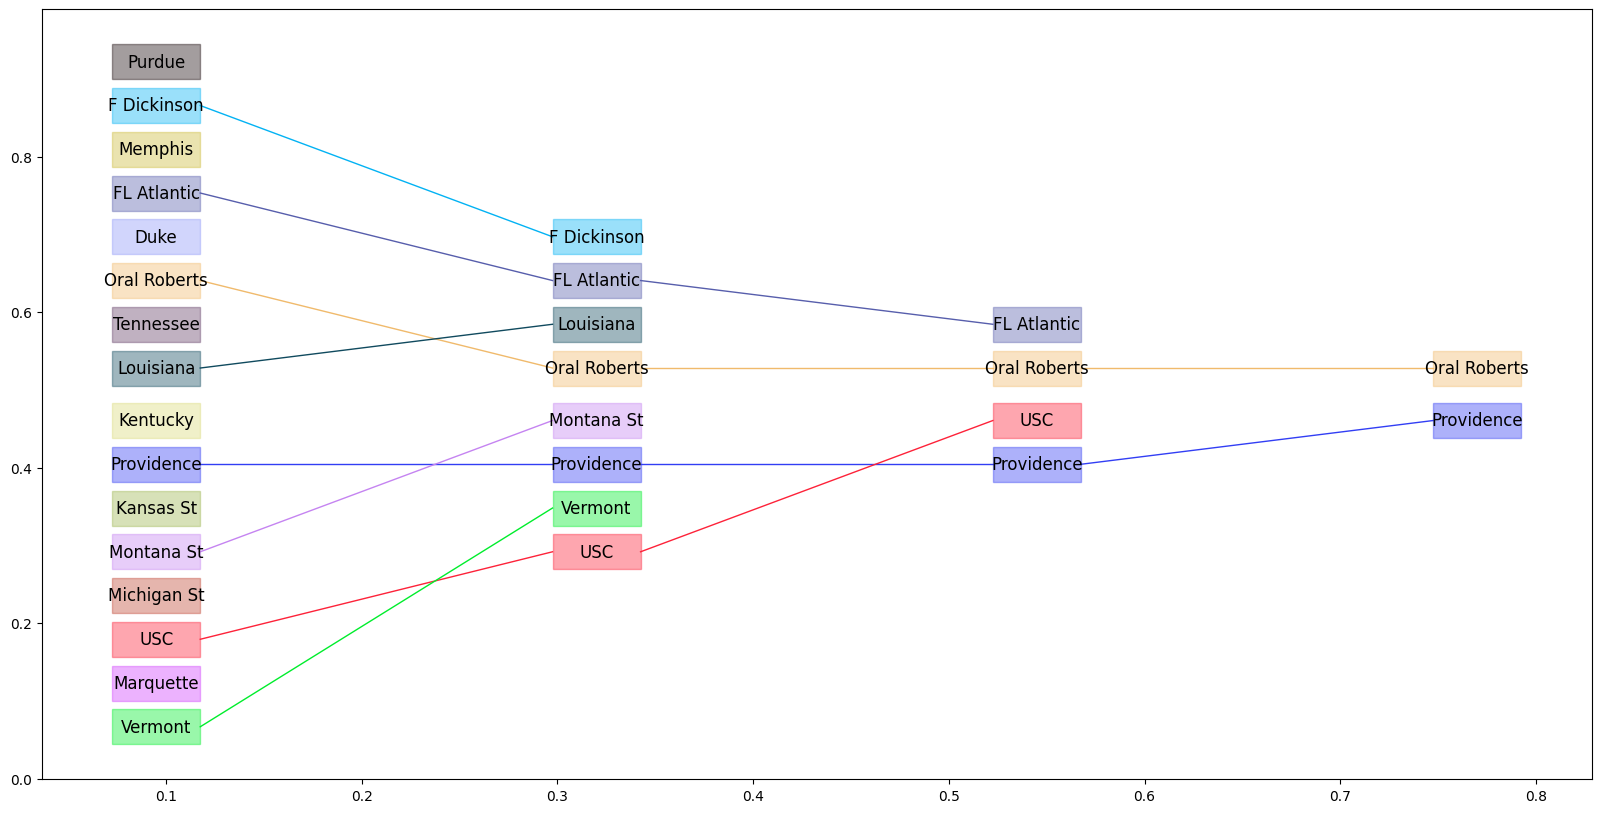

In [14]:
from bracket import Bracket
import matplotlib.pyplot as plt

#test = test[test['Conference'] == 'W']

fig, ax = plt.subplots(figsize=(20, 10))
brk = Bracket(dataFrame=new)
brk.generate_graph(column_identifiers=['TeamAName', 'TeamBName'])
brk.plot(ax)
plt.savefig("bracket_plot/plot.png")

# Test


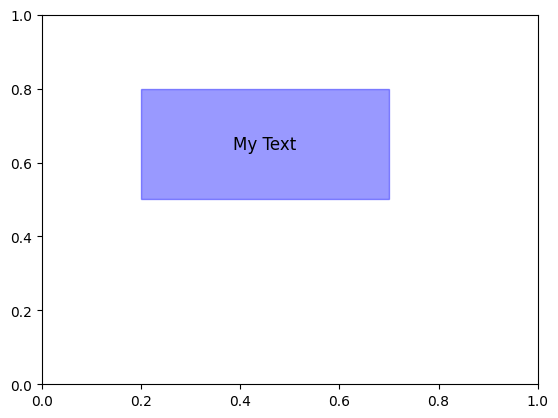

In [14]:
import matplotlib
import matplotlib.pyplot as plt

# Define rectangle properties
rectangle_width = 0.5
rectangle_height = 0.3
rectangle_x = 0.2
rectangle_y = 0.5

# Define text properties
text_content = "My Text"
text_color = "black"
text_fontsize = 12

# Create the figure and axis
fig, ax = plt.subplots()
# Create the rectangle patch
rectangle_patch = matplotlib.patches.Rectangle(xy=(rectangle_x, rectangle_y),
                                             width=rectangle_width, height=rectangle_height,
                                             color='blue', alpha=0.4)

# Add the rectangle to the axis
ax.add_patch(rectangle_patch)

# Calculate text position for centering
text_x_position = rectangle_x + rectangle_width / 2
text_y_position = rectangle_y + rectangle_height / 2

# Create the text annotation
text_annotation = plt.text(x=text_x_position, y=text_y_position, s=text_content,
                                    color=text_color, ha='center', va='center', fontsize=text_fontsize)


plt.show()


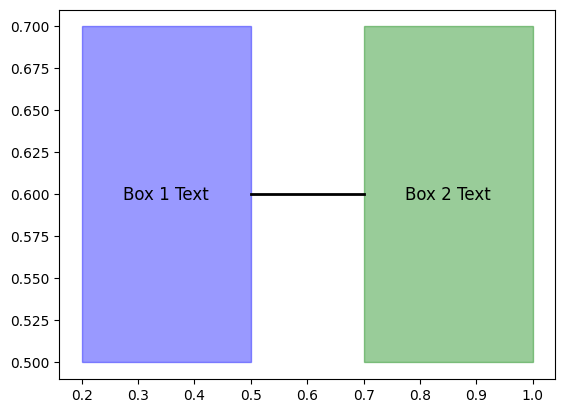

In [15]:
import matplotlib
import matplotlib.pyplot as plt

# Define rectangle properties
box1_width = 0.3  # Width of the first box
box1_height = 0.2  # Height of the first box
box1_x = 0.2  # X-position of the first box
box1_y = 0.5  # Y-position of the first box

box2_width = 0.3  # Width of the second box
box2_height = 0.2  # Height of the second box
box2_x = 0.7  # X-position of the second box
box2_y = 0.5  # Y-position of the second box

# Define text properties
text1_content = "Box 1 Text"
text2_content = "Box 2 Text"
text_color = "black"
text_fontsize = 12

# Create the figure and axis
fig, ax = plt.subplots()

# Create rectangle patches
box1_patch = matplotlib.patches.Rectangle(xy=(box1_x, box1_y),
                                         width=box1_width, height=box1_height,
                                         color='blue', alpha=0.4)
box2_patch = matplotlib.patches.Rectangle(xy=(box2_x, box2_y),
                                         width=box2_width, height=box2_height,
                                         color='green', alpha=0.4)

# Add rectangles to the axis
ax.add_patch(box1_patch)
ax.add_patch(box2_patch)

# Calculate text positions for centering
text1_x = box1_x + box1_width / 2
text1_y = box1_y + box1_height / 2
text2_x = box2_x + box2_width / 2
text2_y = box2_y + box2_height / 2

# Create text annotations
text1_annotation = plt.text(x=text1_x, y=text1_y, s=text1_content,
                             color=text_color, ha='center', va='center', fontsize=text_fontsize)
text2_annotation = plt.text(x=text2_x, y=text2_y, s=text2_content,
                             color=text_color, ha='center', va='center', fontsize=text_fontsize)


# Draw line between boxes (adjust coordinates as needed)
line_x1 = box1_x + box1_width
line_y1 = box1_y + box1_height / 2
line_x2 = box2_x
line_y2 = box2_y + box2_height / 2
plt.plot([line_x1, line_x2], [line_y1, line_y2], color='black', linewidth=2)

# Optional: Set axis limits and labels
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 1])
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')

# Display the plot
plt.show()


In [16]:
games = [1, 2, 3, 4, 5, 6, 7, 8]

sides = [[], []]


top_side = games[0: len(games)//2]
top_side    
botmo_side=games[len(games)//2:]
botmo_side

[5, 6, 7, 8]

In [ ]:
def reorder_bracket_df(df):
    new_order = []
    level = list(df['level'].unique())
    for conf in list(df['Conference'].unique())
        wconf = df[df['Conference'] == conf]
        for l in level:
            level_wconf = wconf[wconf['level'] == l]
            if l == 0:
                games = list(level_wconf.index)
                splits_top = [min(games[0: len(games) // 2]), max(games[0: len(games) // 2]), min(games[len(games) // 2 : ]), max(games[len(games) // 2: ])]
                for i in splits_top: games.remove(i)
                split_bottom = games.copy()
                # create order for split_top
                splits_top.reverse()
                splits_top.insert(0, splits_top[-1])
                splits_top.pop()
                # Create order for split_bottom
                split_bottom.reverse()
                split_bottom.insert(-1, split_bottom[0])
                del split_bottom[0]
                splits_top.extend(split_bottom)
                new_order.extend(splits_top)
                
            if l == 1:
                games = list(level_wconf.index)
                splits = [min(games), max(games), max(games[1:]), min(games[:-1])]
                new_order.extend(splits)
                print(splits)
            if l == 2:
                games = list(level_wconf.index)
                splits = [min(games), max(games)]
                new_order.extend(splits)
            if l == 3:
                games = list(level_wconf.index)
                new_order.extend(games)

        
    

In [61]:
wconf = test[test['Conference'] == 'W']

level = list(wconf['level'].unique())
for l in level:
    level_wconf = wconf[wconf['level'] == l]
    if l == 0:
        games = list(level_wconf.index)
        splits_top = [min(games[0: len(games) // 2]), max(games[0: len(games) // 2]), min(games[len(games) // 2 : ]), max(games[len(games) // 2: ])]
        for i in splits_top: games.remove(i)
        split_bottom = games.copy()
        
        # create order for split_top
        splits_top.reverse()
        splits_top.insert(0, splits_top[-1])
        splits_top.pop()
        
        # Create order for split_bottom
        split_bottom.reverse()
        split_bottom.insert(-1, split_bottom[0])
        del split_bottom[0]
        splits_top.extend(split_bottom)

        print(splits_top)
    if l == 1:
        games = list(level_wconf.index)
        print(games)
        splits = [min(games), max(games), max(games[:-1]), min(games[1:])]
        print(splits)
    if l == 2:
        games = list(level_wconf.index)
        splits = [min(games), max(games)]
        print(splits)
    if l == 3:
        games = list(level_wconf.index)
        new_order.extend(games)

        

[0, 7, 4, 3, 5, 2, 6, 1] [5, 2, 6, 1]
[32, 33, 34, 35]
[32, 35, 34, 33]
[48, 49]


In [24]:
import pandas as pd

# Sample DataFrame
data = {'col1': [1, 2, 3, 4], 'col2': ['a', 'b', 'c', 'd']}
df = pd.DataFrame(data)

# Desired order (list of original indices)
new_order = [2, 0, 3, 1]

# Reorder the DataFrame
df_reordered = df.reindex(new_order)

print(df_reordered)


   col1 col2
2     3    c
0     1    a
3     4    d
1     2    b
